# Finding the next 8Bn

This notebook is for working out the timescales for the next 8 bn.

We have to do some (very basic) modelling to extend out the forecast to estimate when some of them will hit 8Bn, with an open question over the UNPD Low scenario

In [55]:
from matplotlib import pyplot as plt
from pandas import DataFrame, concat, read_csv
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import seaborn as sns
import os

In [5]:
""" Data paths
"""

prepped_data_root = "../../data/prepared_data"

unpd_world_path = os.path.join(prepped_data_root,"unpd_world_indicators.csv")
gbd_world_births_path = os.path.join(prepped_data_root,"gbd_world_births.csv")

In [6]:
""" Functions for extending projections on the basis of an AR(N) model
"""

def df_extender(df, **cols_to_input):
    ''' Generate a dataframe that extends the input

        df: original dataframe
        cols_to_input: key/val of colnames, lists of data

        everything not in cols_to_input is copied from first val
    '''
    new_cols = [c for c in df.columns if c not in cols_to_input.keys()]
    base_df = DataFrame(cols_to_input,
            columns=df.columns)
    for col in new_cols:
        base_df[col] = df[col].iloc[0]

    return base_df

def extend_ar(grouped_df,
        lags,
        values_col="val",
        year_col="year_id",
        extrapolation_length=10):
    ''' Take a DF grouped by the scenario so we have a single timeseries
        and add an extra @n steps using an AR(lags) model
        don't rely on this for a long extrapolation with further analysis
    '''
    ts_len, df_cols = grouped_df.shape
    final_year_df = grouped_df[year_col].max()
    final_year_predict = final_year_df + extrapolation_length
    new_years = [year for year in range(final_year_df+1, final_year_predict+1)]

    ar_model = AutoReg(grouped_df[values_col].to_numpy(), lags=lags).fit()
    new_datapoints = ar_model.predict(ts_len, ts_len+extrapolation_length-1)
    new_fields = {values_col: new_datapoints, year_col: new_years}

    return concat([grouped_df, 
        df_extender(grouped_df, **new_fields)]
        )


In [7]:
""" Load in the data sets
"""

df_unpd = read_csv(unpd_world_path)
df_unpd = df_unpd[df_unpd.Time < 2101] # I dislike overwriting but 2101 seems to be there but null in this dataset

df_gbd = read_csv(gbd_world_births_path)

In [8]:
print(f"UNPD:\n{df_unpd.columns}\n\nGBD\n{df_gbd.columns}")

UNPD:
Index(['Unnamed: 0', 'SortOrder', 'LocID', 'Notes', 'ISO3_code', 'ISO2_code',
       'SDMX_code', 'LocTypeID', 'LocTypeName', 'ParentID', 'Location',
       'VarID', 'Variant', 'Time', 'TPopulation1Jan', 'TPopulation1July',
       'TPopulationMale1July', 'TPopulationFemale1July', 'PopDensity',
       'PopSexRatio', 'MedianAgePop', 'NatChange', 'NatChangeRT', 'PopChange',
       'PopGrowthRate', 'DoublingTime', 'Births', 'Births1519', 'CBR', 'TFR',
       'NRR', 'MAC', 'SRB', 'Deaths', 'DeathsMale', 'DeathsFemale', 'CDR',
       'LEx', 'LExMale', 'LExFemale', 'LE15', 'LE15Male', 'LE15Female', 'LE65',
       'LE65Male', 'LE65Female', 'LE80', 'LE80Male', 'LE80Female',
       'InfantDeaths', 'IMR', 'LBsurvivingAge1', 'Under5Deaths', 'Q5', 'Q0040',
       'Q0040Male', 'Q0040Female', 'Q0060', 'Q0060Male', 'Q0060Female',
       'Q1550', 'Q1550Male', 'Q1550Female', 'Q1560', 'Q1560Male',
       'Q1560Female', 'NetMigrations', 'CNMR', 'BirthsSingle'],
      dtype='object')

GBD
Index(['Unn

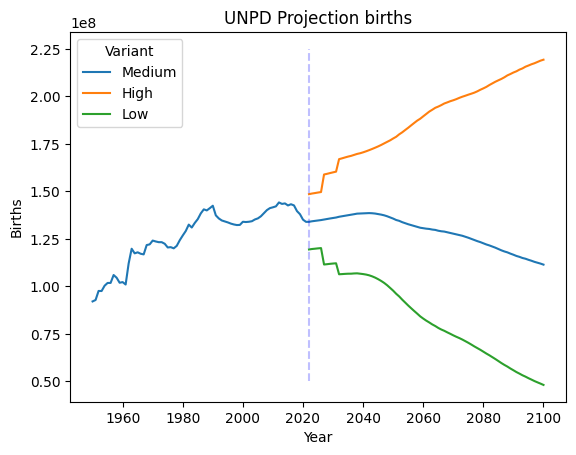

In [9]:
sns.lineplot(data=df_unpd, x="Time", y="BirthsSingle", hue="Variant")
plt.title("UNPD Projection births")
plt.xlabel("Year")
plt.ylabel("Births")
plt.vlines(2022, 0.5e8, 2.25e8, color="b",linestyle="dashed", alpha=0.25)
plt.show()

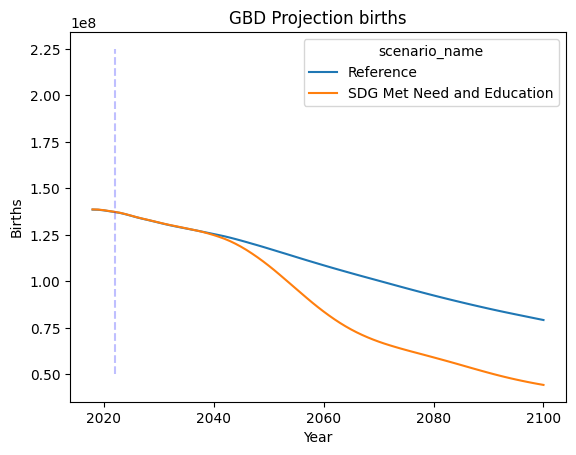

In [10]:
sns.lineplot(data=df_gbd, x="year_id", y="val", hue="scenario_name")
plt.title("GBD Projection births")
plt.xlabel("Year")
plt.ylabel("Births")
plt.vlines(2022, 0.5e8, 2.25e8, color="b",linestyle="dashed", alpha=0.25)
plt.show()

In [11]:
df_unpd.groupby("Variant").BirthsSingle.sum()

Variant
High      1.486133e+10
Low       6.632393e+09
Medium    1.928703e+10
Name: BirthsSingle, dtype: float64

In [12]:
cumulative_births_unpd = df_unpd\
    .sort_values(["Variant","Time"], ascending=True)\
    .set_index(["Variant","Time"])\
    .groupby("Variant")\
    .BirthsSingle\
    .cumsum()\
    .reset_index()

In [13]:
df_comb = concat([
    df_unpd\
        .rename(
            columns={
                "Time":"year_id",
                "BirthsSingle":"val",
                "Variant":"scenario_name"
            }).loc[:, ["year_id","val","scenario_name"]],
    df_gbd.loc[:, ["year_id","val","scenario_name"]]
])

In [14]:
df_comb

,year_id,val,scenario_name
0,1950,9.208326e+07,Medium
1,1951,9.283690e+07,Medium
2,1952,9.760668e+07,Medium
3,1953,9.755584e+07,Medium
4,1954,1.003481e+08,Medium
...,...,...,...
161,2096,4.665493e+07,SDG Met Need and Education
162,2097,4.604602e+07,SDG Met Need and Education
163,2098,4.546677e+07,SDG Met Need and Education
164,2099,4.491790e+07,SDG Met Need and Education


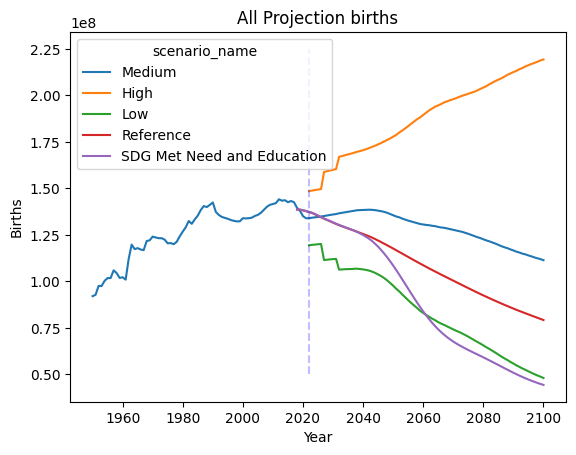

In [15]:
sns.lineplot(data=df_comb, x="year_id", y="val", hue="scenario_name")
plt.title("All Projection births")
plt.xlabel("Year")
plt.ylabel("Births")
plt.vlines(2022, 0.5e8, 2.25e8, color="b",linestyle="dashed", alpha=0.25)
plt.show()

In [16]:
cumulative_births_comb = df_comb[df_comb.year_id > 2022]\
    .sort_values(["scenario_name","year_id"], ascending=True)\
    .set_index(["scenario_name","year_id"])\
    .groupby("scenario_name")\
    .val\
    .cumsum()\
    .reset_index()

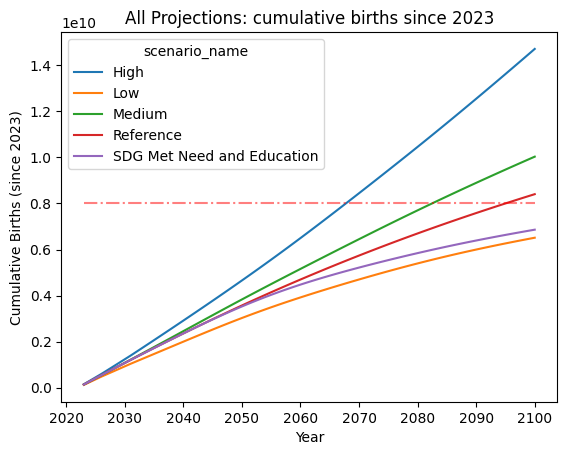

In [17]:
sns.lineplot(data=cumulative_births_comb,
             x="year_id",
             y="val",
             hue="scenario_name")
plt.title("All Projections: cumulative births since 2023")
plt.xlabel("Year")
plt.ylabel("Cumulative Births (since 2023)")
plt.hlines(8e9, 2023, 2100, color="r",linestyle="dashdot", alpha=0.5)
plt.show()

In [18]:
cumulative_births_comb.to_csv("../../data/prepared_data/cumulative_births_combined.csv")

In [19]:
cumulative_births_comb

,scenario_name,year_id,val
0,High,2023,1.488806e+08
1,High,2024,2.980132e+08
2,High,2025,4.474246e+08
3,High,2026,5.970871e+08
4,High,2027,7.559810e+08
...,...,...,...
385,SDG Met Need and Education,2096,6.681574e+09
386,SDG Met Need and Education,2097,6.727620e+09
387,SDG Met Need and Education,2098,6.773087e+09
388,SDG Met Need and Education,2099,6.818004e+09


In [20]:
df_comb_extend_50 = df_comb.groupby("scenario_name").apply(extend_ar, 1, extrapolation_length=50)

cumulative_births_comb_ext50 = df_comb_extend_50[df_comb_extend_50.year_id > 2022]\
    .droplevel("scenario_name")\
    .sort_values(["scenario_name","year_id"], ascending=True)\
    .set_index(["scenario_name","year_id"])\
    .groupby("scenario_name")\
    .val\
    .cumsum()\
    .reset_index()

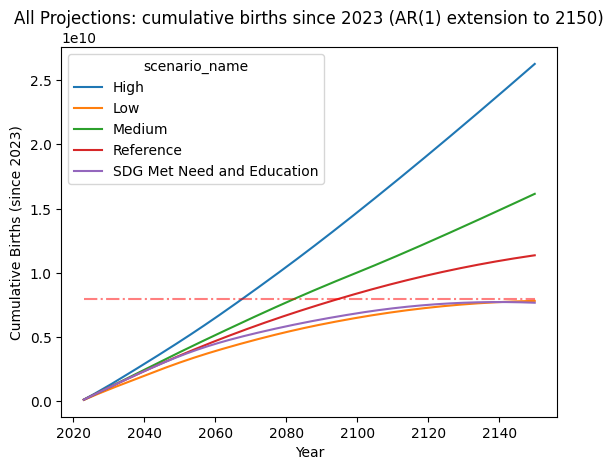

In [21]:
sns.lineplot(data=cumulative_births_comb_ext50,
             x="year_id",
             y="val",
             hue="scenario_name")
plt.title("All Projections: cumulative births since 2023 (AR(1) extension to 2150)")
plt.xlabel("Year")
plt.ylabel("Cumulative Births (since 2023)")
plt.hlines(8e9, 2023, 2150, color="r",linestyle="dashdot", alpha=0.5)
plt.show()

In [22]:
cumulative_births_comb_ext50[cumulative_births_comb_ext50.val >= 8e9]\
    .groupby("scenario_name")\
    .min("year_id")

,year_id,val
scenario_name,,
High,2068,8.051131e+09
Medium,2083,8.066832e+09
Reference,2095,8.002094e+09


## Taking a look at a flat extension for bottom two forecasts

In [23]:
# just take the last forecast (2100) val for each projection and fix that as birth rate

final_forecast_ref_val = df_comb_extend_50[(df_comb_extend_50.scenario_name=="SDG Met Need and Education") & (df_comb_extend_50.year_id==2100)].val
df_comb_extend_50.loc[(df_comb_extend_50.scenario_name=="SDG Met Need and Education") & (df_comb_extend_50.year_id > 2100),"val"] = 50*[final_forecast_ref_val]

final_forecast_ref_val = df_comb_extend_50[(df_comb_extend_50.scenario_name=="Low") & (df_comb_extend_50.year_id==2100)].val
df_comb_extend_50.loc[(df_comb_extend_50.scenario_name=="Low") & (df_comb_extend_50.year_id > 2100),"val"] = 50*[final_forecast_ref_val]


In [24]:
cumulative_births_comb_ext50 = df_comb_extend_50[df_comb_extend_50.year_id > 2022]\
    .droplevel("scenario_name")\
    .sort_values(["scenario_name","year_id"], ascending=True)\
    .set_index(["scenario_name","year_id"])\
    .groupby("scenario_name")\
    .val\
    .cumsum()\
    .reset_index()

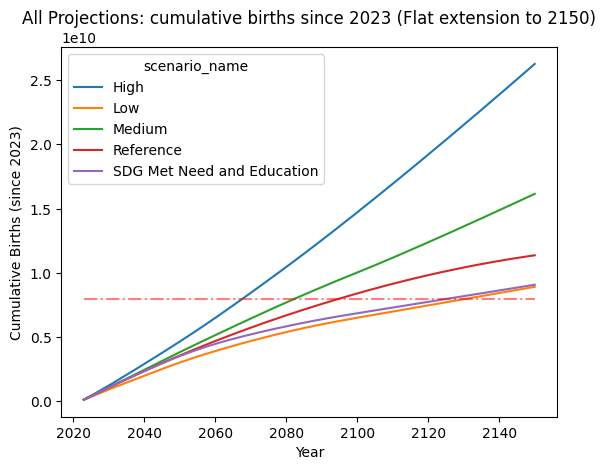

In [25]:
sns.lineplot(data=cumulative_births_comb_ext50,
             x="year_id",
             y="val",
             hue="scenario_name")
plt.title("All Projections: cumulative births since 2023 (Flat extension to 2150)")
plt.xlabel("Year")
plt.ylabel("Cumulative Births (since 2023)")
plt.hlines(8e9, 2023, 2150, color="r",linestyle="dashdot", alpha=0.5)
plt.show()

In [26]:
# this can then be our figures (for now we ignore the lowest two to avoid extrapolating)

n8b = cumulative_births_comb_ext50[cumulative_births_comb_ext50.val >= 8e9]\
    .groupby("scenario_name")\
    .min("year_id")

n8b

,year_id,val
scenario_name,,
High,2068,8.051131e+09
Low,2131,8.005052e+09
Medium,2083,8.066832e+09
Reference,2095,8.002094e+09
SDG Met Need and Education,2126,8.016662e+09


In [27]:
# write this so we can start doing some analysis
cumulative_births_comb_ext50[cumulative_births_comb_ext50.val >= 8e9]\
    .groupby("scenario_name")\
    .min("year_id")\
    .to_csv("../../data/prepared_data/date_for_8bn.csv")

In [28]:
df_maroc = read_csv("../../data/unpd_data/WPP2022_Demographic_Indicators_Medium.csv", low_memory=False)
df_maroc_other = read_csv("../../data/unpd_data/WPP2022_Demographic_Indicators_OtherVariants.csv", low_memory=False)

In [29]:
df_maroc["Variant"] = "Medium"
df_maroc["val"] = df_maroc.Births*1_000
df_maroc_other["val"] = df_maroc_other.Births*1_000

In [30]:
df_maroc = df_maroc[df_maroc.Location=="Morocco"]
df_maroc_other = df_maroc_other[(df_maroc_other.Location=="Morocco") & (df_maroc_other.Variant=="High")]

In [31]:
cumulative_births_maroc = df_maroc[df_maroc.Time > 2022]\
    .sort_values(["Variant","Time"], ascending=True)\
    .set_index(["Variant","Time"])\
    .groupby("Variant")\
    .val\
    .cumsum()\
    .reset_index()

cumulative_births_maroc_other = df_maroc_other[(df_maroc_other.Time > 2022) & (df_maroc_other.Time < 2101)]\
    .sort_values(["Variant","Time"], ascending=True)\
    .set_index(["Variant","Time"])\
    .groupby("Variant")\
    .val\
    .cumsum()\
    .reset_index()

In [32]:
n8b.columns = list(n8b.columns)

In [33]:
n8b = n8b.reset_index()

In [34]:
n8b.loc[:,["scenario_name","year_id"]]\
    .merge(cumulative_births_maroc,
        left_on=["scenario_name","year_id"],
        right_on=["Variant", "Time"])

,scenario_name,year_id,Variant,Time,val
0,Medium,2083,Medium,2083,33386877.0


In [35]:
n8b.loc[:,["scenario_name","year_id"]]\
    .merge(cumulative_births_maroc_other,
        left_on=["scenario_name","year_id"],
        right_on=["Variant", "Time"])

,scenario_name,year_id,Variant,Time,val
0,High,2068,High,2068,34807957.0


In [36]:
cumulative_births_maroc_other
df_maroc_other.Births

64960    713.039
64961    707.577
64962    700.658
64963    693.803
64964    688.730
          ...   
65035    841.243
65036    843.246
65037    842.914
65038    844.449
65039        NaN
Name: Births, Length: 80, dtype: float64

In [37]:
df_maroc[(df_maroc.Time > 2022) & (df_maroc.Time < 2084)].val.sum()

33386877.0

In [38]:
8_000_000_000/195 # (check an est for average per country)

41025641.025641024

In [39]:
df_all_unpd = read_csv("../../data/unpd_data/WPP2022_Demographic_Indicators_Medium.csv", low_memory=False)

In [40]:
df_all_unpd.columns

Index(['SortOrder', 'LocID', 'Notes', 'ISO3_code', 'ISO2_code', 'SDMX_code',
       'LocTypeID', 'LocTypeName', 'ParentID', 'Location', 'VarID', 'Variant',
       'Time', 'TPopulation1Jan', 'TPopulation1July', 'TPopulationMale1July',
       'TPopulationFemale1July', 'PopDensity', 'PopSexRatio', 'MedianAgePop',
       'NatChange', 'NatChangeRT', 'PopChange', 'PopGrowthRate',
       'DoublingTime', 'Births', 'Births1519', 'CBR', 'TFR', 'NRR', 'MAC',
       'SRB', 'Deaths', 'DeathsMale', 'DeathsFemale', 'CDR', 'LEx', 'LExMale',
       'LExFemale', 'LE15', 'LE15Male', 'LE15Female', 'LE65', 'LE65Male',
       'LE65Female', 'LE80', 'LE80Male', 'LE80Female', 'InfantDeaths', 'IMR',
       'LBsurvivingAge1', 'Under5Deaths', 'Q5', 'Q0040', 'Q0040Male',
       'Q0040Female', 'Q0060', 'Q0060Male', 'Q0060Female', 'Q1550',
       'Q1550Male', 'Q1550Female', 'Q1560', 'Q1560Male', 'Q1560Female',
       'NetMigrations', 'CNMR'],
      dtype='object')

In [41]:
cumulative_births_all = df_all_unpd[(df_all_unpd.Location=="World") & (df_all_unpd.Time > 2022)]\
    .sort_values(["Variant","Time"], ascending=True)\
    .set_index(["Variant","Time"])\
    .groupby("Variant")\
    .Births\
    .cumsum()\
    .reset_index()

In [42]:
cumulative_births_all["actual_births"] = cumulative_births_all.Births*1_000

In [43]:
cumulative_births_all

,Variant,Time,Births,actual_births
0,Medium,2023,1.342796e+05,1.342796e+08
1,Medium,2024,2.687642e+05,2.687642e+08
2,Medium,2025,4.034763e+05,4.034763e+08
3,Medium,2026,5.383834e+05,5.383834e+08
4,Medium,2027,6.735817e+05,6.735817e+08
...,...,...,...,...
74,Medium,2097,9.697536e+06,9.697536e+09
75,Medium,2098,9.809993e+06,9.809993e+09
76,Medium,2099,9.921998e+06,9.921998e+09
77,Medium,2100,1.003345e+07,1.003345e+10


In [44]:
cumulative_births_all[cumulative_births_all.Time == 2083]

,Variant,Time,Births,actual_births
60,Medium,2083,8066831.684,8.066832e+09


## E4A births analysis

In [45]:
import pandas as pd
e4a_data = "../../data/e4a_data/2022 05 01 E4A model data equations charts.xlsx"
df_e4aTLTL, df_e4aGL = pd.read_excel(e4a_data, 1, index_col=0), pd.read_excel(e4a_data, 2, index_col=0)

In [46]:
#print(df_e4aGL)
interesting_idxs = [idx for idx in df_e4aTLTL.index if ("pop" in idx.lower()) or ("birth" in idx.lower())]
keep_idx = [idx for i, idx in enumerate(interesting_idxs) if i in [1,2,4,6]]
print(keep_idx)

['"Births Mp/y"', '"Population below 15 k$/p/y Mp"', 'Population Mp', 'Working age population Mp']


In [47]:
df_e4a_filteredGL, df_e4a_filteredTLTL = df_e4aGL.loc[keep_idx,:].T, df_e4aTLTL.loc[keep_idx,:].T

In [48]:
df_e4a_filteredGL["scenario"] = "Great Leap"
df_e4a_filteredTLTL["scenario"] = "Too Little Too Late"

In [49]:
df_e4a = pd.concat([df_e4a_filteredGL.reset_index(), df_e4a_filteredTLTL.reset_index()]).rename(columns={"index":"year_id"})
df_e4a["Births"] = (df_e4a['"Births Mp/y"']*1_000_000).astype(int)

In [50]:
df_e4a.to_csv("../../data/prepared_data/e4a_combined_labelled.csv")

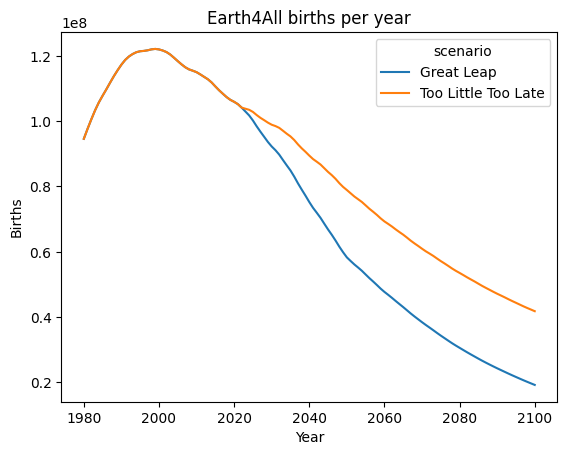

In [51]:
sns.lineplot(data=df_e4a,
             x="year_id",
             y="Births",
             hue="scenario")
plt.title("Earth4All births per year")
plt.xlabel("Year")
plt.ylabel("Births")
#plt.hlines(8e9, 2023, 2150, color="r",linestyle="dashdot", alpha=0.5)
plt.show()

In [52]:
cumulative_births_e4a = df_e4a[df_e4a.year_id > 2022]\
    .sort_values(["scenario","year_id"], ascending=True)\
    .set_index(["scenario","year_id"])\
    .groupby("scenario")\
    .Births\
    .cumsum()\
    .reset_index()\
    .rename(columns={"Births": "CumulativeBirths"})

2023

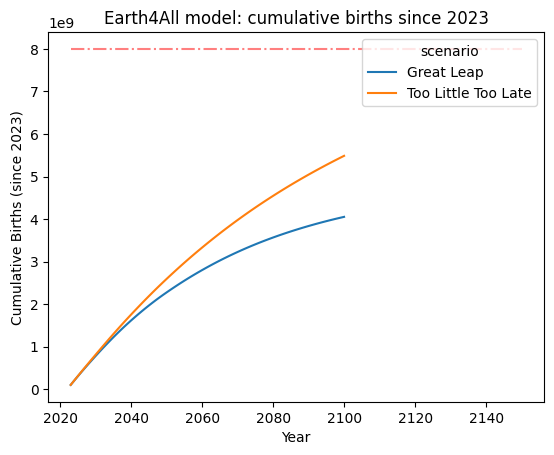

In [54]:
sns.lineplot(data=cumulative_births_e4a,
             x="year_id",
             y="CumulativeBirths",
             hue="scenario")
plt.title("Earth4All model: cumulative births since 2023")
plt.xlabel("Year")
plt.ylabel("Cumulative Births (since 2023)")
plt.hlines(8e9, 2023, 2150, color="r",linestyle="dashdot", alpha=0.5)
plt.show()

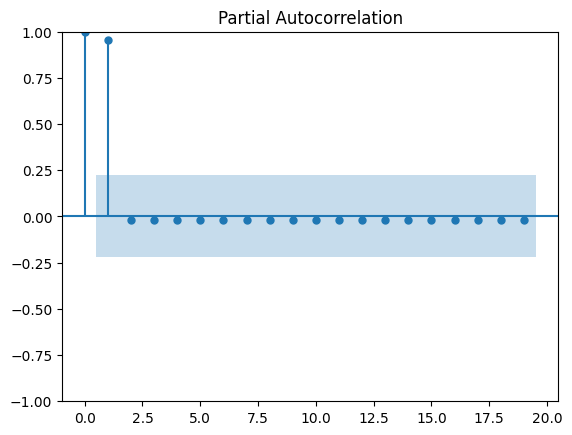

In [67]:
plt.close()
plot_pacf(cumulative_births_e4a[cumulative_births_e4a.scenario=="Great Leap"].CumulativeBirths)
plt.show()

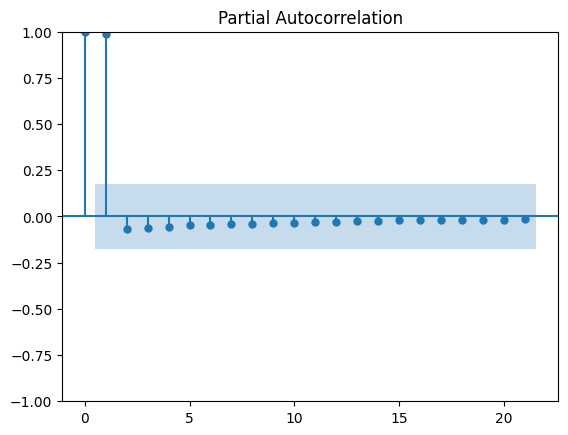

In [77]:
plt.close()
plot_pacf(df_e4a[df_e4a.scenario=="Too Little Too Late"].Births)
plt.show()

In [74]:
df_e4a_ext = df_e4a.groupby("scenario").apply(extend_ar, 1, extrapolation_length=50, values_col="Births")


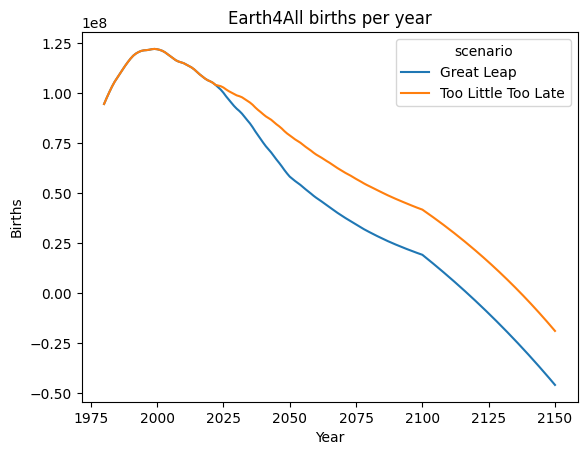

In [76]:
sns.lineplot(data=df_e4a_ext,
             x="year_id",
             y="Births",
             hue="scenario")
plt.title("Earth4All births per year")
plt.xlabel("Year")
plt.ylabel("Births")
#plt.hlines(8e9, 2023, 2150, color="r",linestyle="dashdot", alpha=0.5)
plt.show()